### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mnist
from sklearn.utils import shuffle
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier


### Load dataset
#### For loading large MNIST dataset we use mnist.py file 
#### First we need init mnist(for dowenloading dataset)
### Dont run this second time

In [2]:
mnist.init()

Download complete.
Save complete.



#### Now load dataset with mnist.load()


In [2]:
x_train, y_train, x_test, y_test = mnist.load()
img_shape = (28,28)

In [4]:
y_test

array([7, 2, 1, ..., 4, 5, 6], dtype=uint8)

#### We have a 60000 train and 10000 test  images 

In [3]:
print("Train images shape:",x_train.shape)
print("Test images shape:",x_test.shape)

Train images shape: (60000, 784)
Test images shape: (10000, 784)


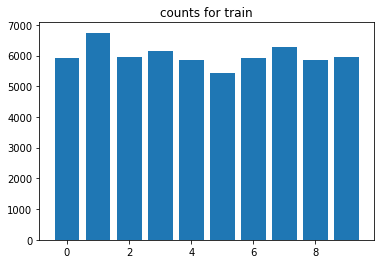

In [4]:
digits, counts = np.unique(y_train, return_counts=1)
plt.bar(digits,counts)
plt.title("counts for train");

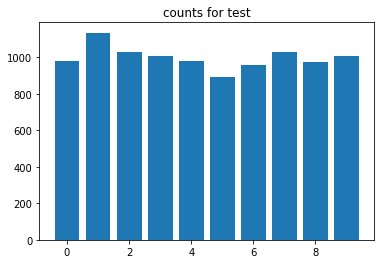

In [5]:
digits, counts = np.unique(y_test, return_counts=1)
plt.bar(digits,counts)
plt.title("counts for test");

### In dataset each image represented by (768,) size vector, if you want to see image you need reshape this vectore to (28,28) array

In [6]:
# simple function for plot random images
def plot_images(X,y,size=10):
    for i in range(10):
        idx = np.random.randint(low = 0, high = X.shape[0],size = 1)
        img = X[idx]
        label = y[idx]
        plt.imshow(img.reshape(28,28), cmap='gray')
        plt.title(str(label[0]))
        plt.show()

### Plot random images

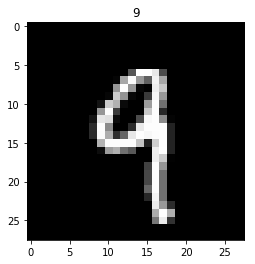

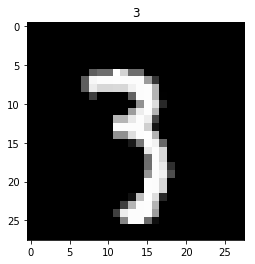

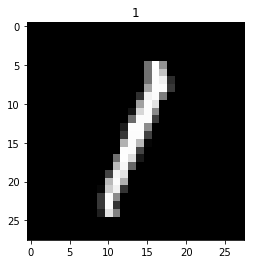

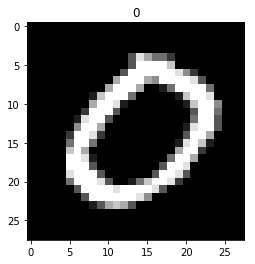

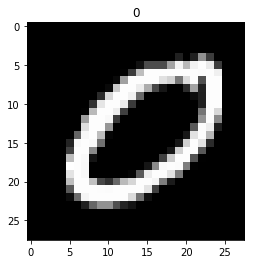

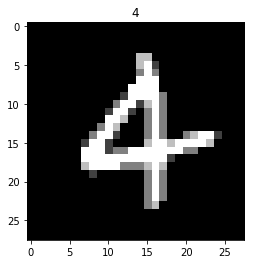

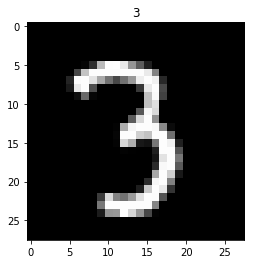

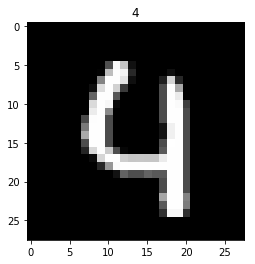

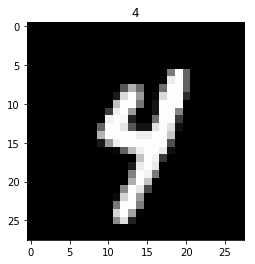

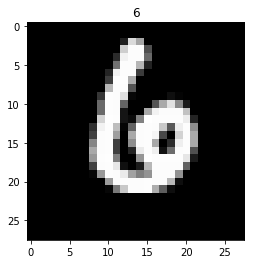

In [7]:
plot_images(x_train,y_train)

## Now lets build classifer only for 0 and 1

### Separate data

In [8]:
X_1 = x_train[y_train==1]
Y_1 = y_train[y_train==1]
X_0 = x_train[y_train==0]
Y_0 = y_train[y_train==0]

X_1_test = x_test[y_test==1]/255.0
Y_1_test = y_test[y_test==1]
X_0_test = x_test[y_test==0]/255.0
Y_0_test = y_test[y_test==0]

X_train = np.concatenate((X_1,X_0), axis = 0)
Y_train = np.concatenate((Y_1,Y_0),axis = 0)

X_test = np.concatenate((X_1_test,X_0_test), axis = 0)
Y_test = np.concatenate((Y_1_test,Y_0_test),axis = 0)

X_train, Y_train = shuffle(X_train, Y_train, random_state=0)
X_test, Y_test = shuffle(X_test, Y_test, random_state=0)



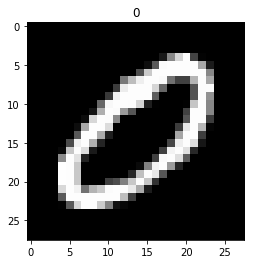

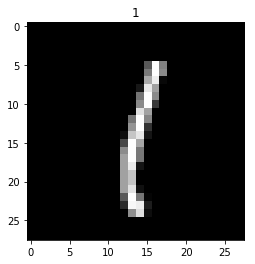

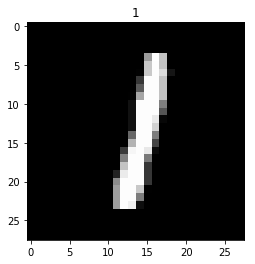

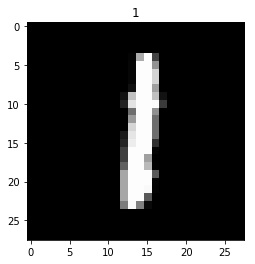

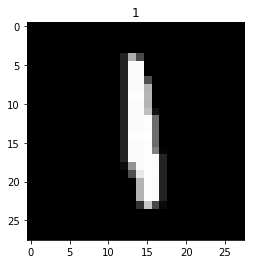

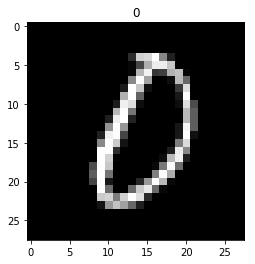

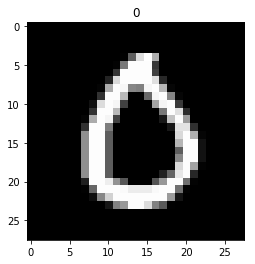

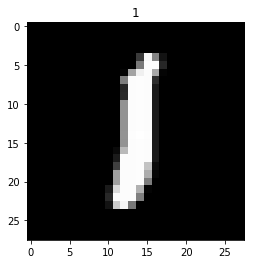

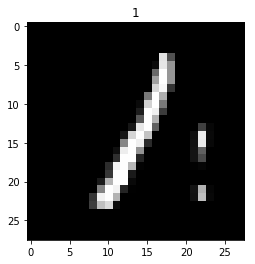

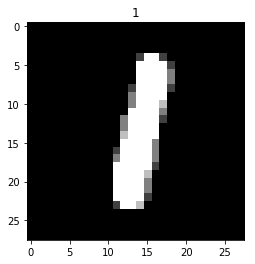

In [9]:
plot_images(X_test,Y_test)

### Dimentionality reduction

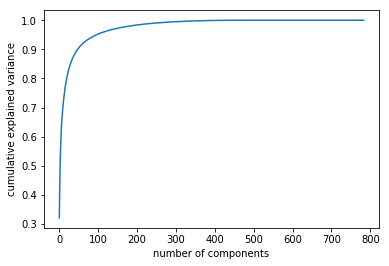

In [10]:
pca = PCA().fit(X_train)
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

In [11]:
pca = PCA(n_components=2)
pca.fit(X_train)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

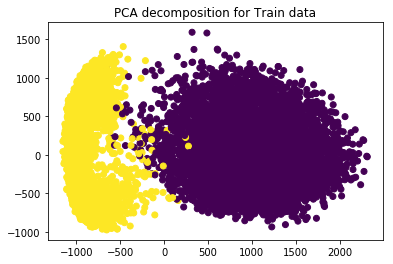

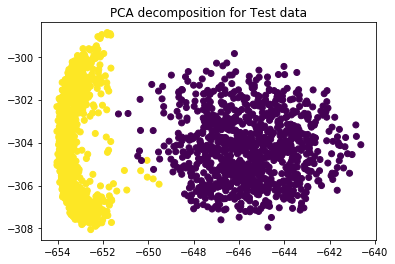

In [13]:
plt.scatter(X_train_pca[:,0],X_train_pca[:,1],c = Y_train)
plt.title("PCA decomposition for Train data")
plt.show()
plt.scatter(X_test_pca[:,0],X_test_pca[:,1],c = Y_test)
plt.title("PCA decomposition for Test data")
plt.show();

### Let's find some important features

In [14]:
#sume off pixels in centre off image
def central_sum(x,img_shape,size=[4,4]):
    img = x.reshape(img_shape)
    return img[14-size[0]:14+size[1],14-size[0]:14+size[1]].sum()

#summ off all pixels where we have zero
def zeros_count(x):
    return sum(x == 0)

#sum off horizontal layers with given range
def hoizontal_sums(x,img_shape,layer = 4):
    img = x.reshape(img_shape)
    sums = [img[:,layer*i:layer*(i+1)].sum() for i in range(0,int(img_shape[1]/layer))]
    return sum(sums)

# plot image and features
def plot_features(x,img_shape):
    cs = central_sum(x,img_shape)
    zc = zeros_count(x)
    hs = hoizontal_sums(x,img_shape)
    plt.imshow(x.reshape(img_shape))
    plt.title("central sum:{0}, zeros count:{1}, hoirizontal sums:{2}".format(cs,zc,hs))
    plt.show()

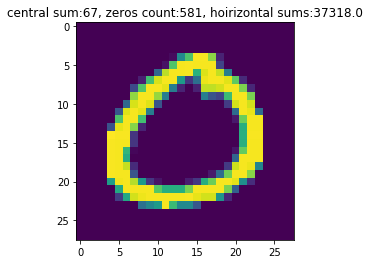

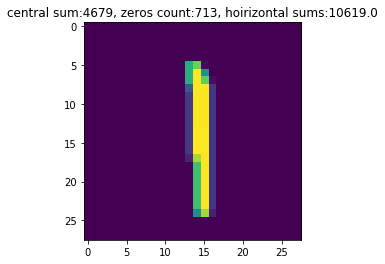

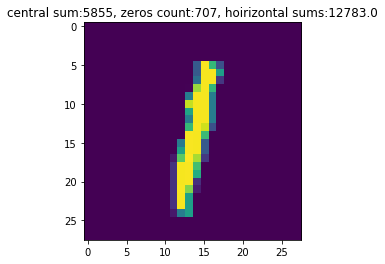

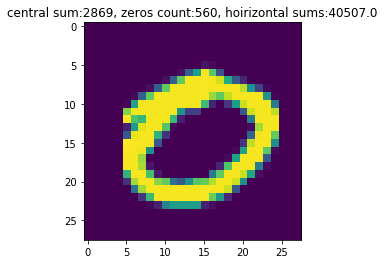

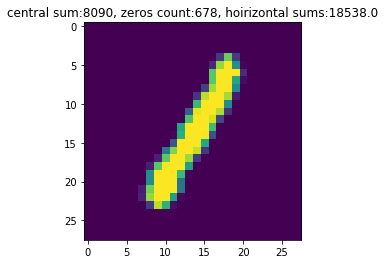

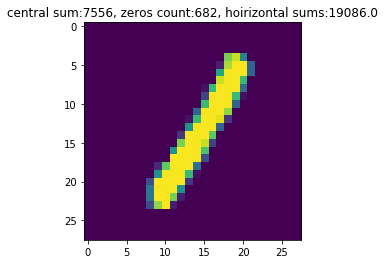

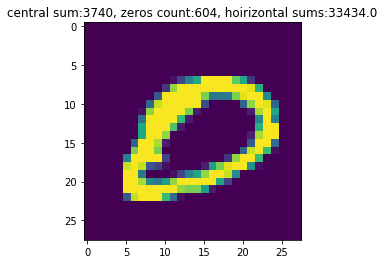

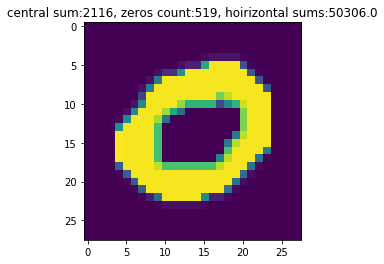

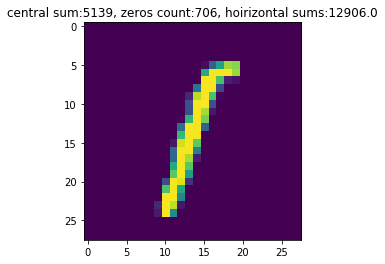

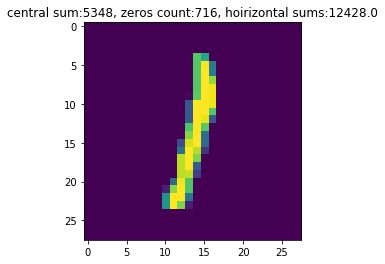

In [15]:
for i in range(10):
    plot_features(X_train[i],img_shape)

### Now finde new features for all data

In [16]:
X_train_f = np.array([np.array([central_sum(x,img_shape),zeros_count(x),hoizontal_sums(x,img_shape)]) for x in X_train])
X_test_f = np.array([np.array([central_sum(x,img_shape),zeros_count(x),hoizontal_sums(x,img_shape)]) for x in X_test])


#### Scaling new dataset

In [17]:
std_scl = StandardScaler()
std_scl.fit(X_train_f)
X_train_f = std_scl.transform(X_train_f)
X_test_f = std_scl.transform(X_test_f)


### Classification with random forest

In [18]:
clf = RandomForestClassifier(n_estimators=100, max_depth=3,random_state=0)
clf.fit(X_train_f, Y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=3, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [19]:
clf.score(X_train_f,Y_train)

0.9858665613896566

In [20]:
y_pred = clf.predict(X_test_f)
print(classification_report(Y_test,y_pred))

              precision    recall  f1-score   support

           0       0.85      1.00      0.92       980
           1       1.00      0.85      0.92      1135

    accuracy                           0.92      2115
   macro avg       0.92      0.92      0.92      2115
weighted avg       0.93      0.92      0.92      2115



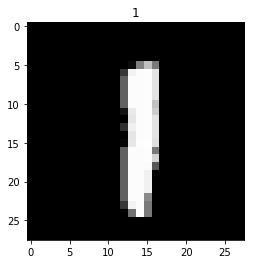

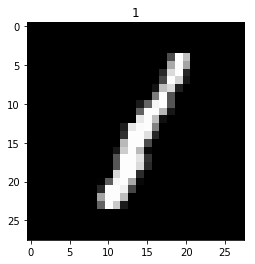

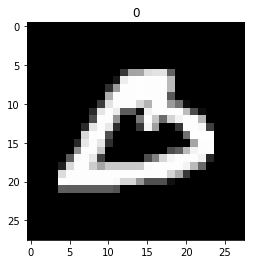

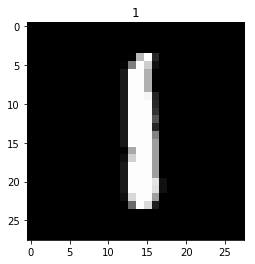

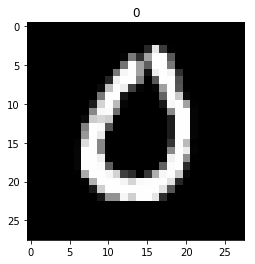

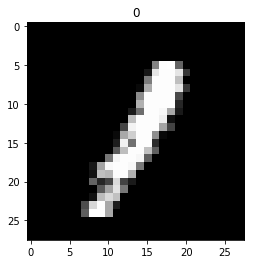

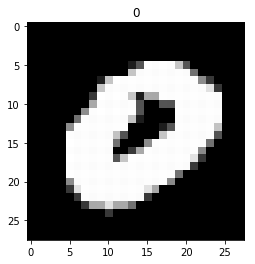

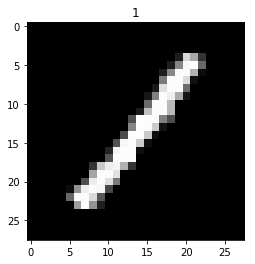

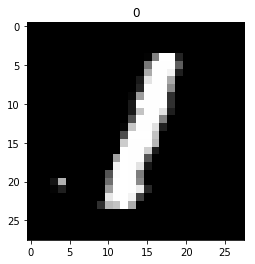

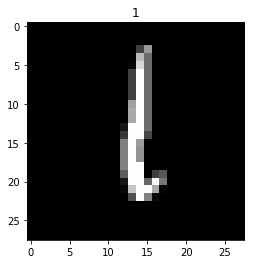

In [22]:
#plot predictions 
plot_images(X_test,y_pred,size = 20)

In [23]:
def plot_feature_importance(model,features):
    importances = model.feature_importances_
    indices = np.argsort(importances)

    plt.title('Feature Importances')
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

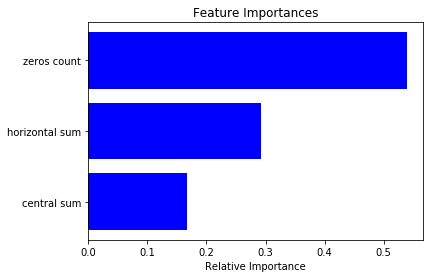

In [24]:
plot_feature_importance(clf, features=["central sum","zeros count","horizontal sum"])

### Grid Search

In [ ]:
parameters = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]}
random_forest_estim = RandomForestClassifier()
grid_search = GridSearchCV(random_forest_estim, parameters)
grid_search.fit(X_train_f,Y_train)

print("=================Classification Report on Train====================")
Y_pred_train = grid_search.best_estimator_.predict(X_train_f)
print(classification_report(Y_train,Y_pred))
print("\n")
print("=================Classification Report on Test====================")
Y_pred_test = grid_search.best_estimator_.predict(X_test_f)
print(classification_report(Y_test,Y_pred))